# Code framework (i.e. you can leave this alone)

## Imports

In [ ]:
%%capture
import numpy as np
import sys
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib as matplot
import math
import time

!pip install scprep
import scprep
!pip install ndsplines
import ndsplines

from scipy import interpolate, misc
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from scipy.interpolate import CubicSpline
from scipy.stats import spearmanr
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso, SGDClassifier, LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

## Data loading

In [ ]:
def load_germ_data_file(filename):
    df = pd.read_csv(filename, names = ['seedname','germinated'])
    df.set_index('seedname', inplace=True)
    df = df.astype('bool')
    return df

def load_oxygen_data_file(filename):
    df = pd.read_csv(filename)
    return df

def load_drive_data_file(file_location, header=True):
    scprep.io.download.download_google_drive(file_location, "data_file.csv")
    if not header:
        data_file_df = pd.read_csv("data_file.csv", header=None)
    else:
        data_file_df = pd.read_csv("data_file.csv")
    return data_file_df

## Data preprocessing

In [ ]:
def preprocess_oxygen_data(oxygen_df):
    if not 'Seconds' in oxygen_df.columns:
        oxygen_df['Seconds'] = oxygen_df['Hours'] * 3600
    oxygen_df['Seconds'] -= np.min(oxygen_df['Seconds'])
    oxygen_df['Hours'] -= np.min(oxygen_df['Hours'])
    time_columns = oxygen_df[['Seconds', 'Hours']]
    # normalization
    oxygen_columns = oxygen_df.drop(['Seconds', 'Hours'], axis=1)
    nega = np.min(oxygen_columns, axis=0)
    nega = nega * (nega < 0)
    oxygen_columns = oxygen_columns - nega
    oxygen_columns = oxygen_columns / np.max(oxygen_columns, axis=0)
    return pd.concat([time_columns, oxygen_columns], axis=1)

# deprecated
def preprocess(oxygen_data_df, germination_data_df, no_germdata = False):
    oxygen_data_df['seconds'] -= np.min(oxygen_data_df['seconds'])

    # calculate the timepoints of germination (in hours)
    total_oxygen_recording_duration = np.max(oxygen_data_df['seconds'])
    if no_germdata == True:
        return oxygen_data_df
    germination_seconds = germination_data_df['germpoint'] * (total_oxygen_recording_duration / total_germination_images)
    germination_data_df['germhour'] = germination_seconds/3600 # calculate the hours after which germination took place
    germination_data_df.drop((germination_data_df[germination_data_df['germpoint'] == 0]).index, inplace=True)
    return oxygen_data_df, germination_data_df
# deprecated
def preprocess_astec_data(astec_data_df):
    astec_data_df = astec_data_df[['name', 'Seed status', 'IMT(hrs)', 'IMO(%sat)', 'Slin(hours)', 'Slin(%sat)', 'COP(%sat)', 'COT(hrs)', 'OMR', 'RGT']]
    astec_data_df.set_index('name', inplace=True)
    astec_data_df.rename(columns={'Seed status':'germ_status',
                                        'IMT(hrs)':'IMT_hours',
                                        'IMO(%sat)':'IMT_fraction',
                                        'Slin(hours)':'Slin_hours',
                                        'Slin(%sat)':'Slin_fraction',
                                        'COP(%sat)':'COP_fraction',
                                        'COT(hrs)':'COP_hours'}, inplace=True)
    return astec_data_df.T

## Applying interpolating to create uniform timepoints

In [ ]:
def interpolate_oxygen_data(oxygen_data_df):
    irregular = np.array(oxygen_data_df['Seconds']).astype('float64')
    regular = np.arange(start=0, stop=np.max(oxygen_data_df['Seconds']), step = 600).astype('float64')
    def interpolate_func(column):
        interpolator_object = interpolate.interp1d(irregular, np.array(column.values), fill_value="extrapolate")
        interpolated_column = interpolator_object(regular)
        return interpolated_column

    interpolated_oxygen_df = oxygen_data_df.drop('Seconds', axis = 1).apply(interpolate_func, axis=0)
    interpolated_oxygen_df['Seconds'] = regular
    interpolated_oxygen_df['Hours'] = interpolated_oxygen_df['Seconds']/3600
    interpolated_oxygen_df.set_index('Hours', inplace=True)
    return interpolated_oxygen_df

## Fitting B-splines to interpolated data

In [ ]:
def fit_spline_curve(curve_data):
    x_points = np.arange(0, len(curve_data), 1).astype('double')
    knots = np.arange(0, len(curve_data), len(curve_data)/15).astype('double')
    degrees = np.array([4])
    spline = ndsplines.make_lsq_spline(x_points, curve_data, [knots], degrees)
    return spline(x_points)

def fit_spline_curves(interpolated_oxygen_df):
    splines = pd.DataFrame(columns = interpolated_oxygen_df.columns) # B-spline fitted curves
    for curve_name in interpolated_oxygen_df:
        curve_data = interpolated_oxygen_df[curve_name].to_numpy().astype('double')
        splines[curve_name] = fit_spline_curve(curve_data)
    splines['hours'] = interpolated_oxygen_df.index
    splines.set_index('hours', inplace=True)
    return splines


## Calculation of the descriptive statistics
Hier gaan we de volgende eigenschappen berekenen, per curve:
- max_value = de maximale zuurstofwaarde
- min_value = de minimale zuurstofwaarde
- avg_value = de gemiddelde zuurstofwaarde genomen over de gehele meting
- avg_derivative = gemiddelde waarde van de afgeleide van de curve
- max_derivative = maximale (dus positieve) waarde die de curve aanneemt
- R25 = de tijd wanneer het zuurstofpercentage afneemt tot 25% van de beginwaarde
- R50 = hetzelfde als hierboven maar met 50%
- R75 = hetzelfde als hierboven maar met 75%
- IMT = de tijd waarop het zuurstofverbruik significant stijgt (gebaseerd op parameter)
- OMR = de maximaal negatieve waarde die de afgeleide aanneemt
- COP = het zuurstofpercentage waarop het zuurstofverbruik afneemt
- RGT = relative germ. time, de intersect van de nullijn en de lineaire OMR lijn
- RE = radicle emergence, het moment van kieming, geidentificeerd met foto's van de zaadjes

In [ ]:
# helper functions
IMT_parameter = 0.25

def calculate_IMT_point(second_derivative):
    minimum = np.min(second_derivative)
    for i, value in enumerate(second_derivative):
        if value < minimum*IMT_parameter:
            return i, value
    raise Exception('Error occurred in calculate_IMT_point')

def calculate_COP_point(second_derivative):
    OMR = 0
    maximum = np.max(second_derivative)
#    reverse_derivative = second_derivative[::-1]
    for i, value in enumerate(second_derivative):
#        if reverse_derivative[i-1] < 0 and value == 0:
        if value == maximum:
            return i, value
    raise Exception('Error occurred in calculate_COP')

def calculate_R_value_points(curve):
    R75 = R50 = R25 = 0
    R75_threshold = np.max(curve) * 0.75
    R50_threshold = np.max(curve) * 0.50
    R25_threshold = np.max(curve) * 0.25
    for i, value in enumerate(curve):
        R75 = i
        if value < R75_threshold:
            break
    for i, value in enumerate(curve):
        R50 = i
        if value < R50_threshold:
            break
    for i, value in enumerate(curve):
        R25 = i
        if value < R25_threshold:
            break
    return R25, R50, R75

def calculate_OMR_point(curve):
    derivative = np.diff(curve)
    minimum = np.min(derivative)
    return np.where(derivative == minimum)[0][0], minimum

def calculate_integral(curve):
    return np.concatenate(([1], curve)).cumsum()

def calculate_max_integral_value(curve):
    integral = calculate_integral(curve)
    return np.max(integral)

def calculate_mean_integral_value(curve):
    integral = calculate_integral(curve)
    return np.mean(integral)

def calculate_integral_R50(curve):
    integral = calculate_integral(curve)
    max = np.max(integral)
    for i, point in enumerate(integral):
        if point > max/2:
            return i
    return 0

def calculate_integral_R25(curve):
    integral = calculate_integral(curve)
    max = np.max(integral)
    for i, point in enumerate(integral):
        if point > max*0.25:
            return i
    return 0

# set up dataframe for the descriptive statistics
def calculate_statistics(splines, germ_df, no_germdata = False):
    index_rows = ['max_value','min_value','avg_value','avg_derivative',
            'R75_hours','R50_hours','R25_hours','IMT_x','IMT_hours','IMT_y','OMR_point', 'OMR_hours','COP_x','COP_hours','COP_y','RGT_x','RGT_hours',
            'max_integral','mean_integral','integral_R50','integral_R25','germinated']
    if no_germdata == True:
        index_rows = ['max_value','min_value','avg_value','avg_derivative',
            'R75_hours','R50_hours','R25_hours','IMT_x','IMT_hours','IMT_y','OMR_point','OMR_hours','COP_x','COP_hours','COP_y','RGT_x','RGT_hours',
            'max_integral','mean_integral','integral_R50','integral_R25',]
    statistics = pd.DataFrame(index=index_rows)

    # calculate descriptive statistics
    for spline_name, spline in splines.items():
        if (no_germdata == False) and (not spline_name in germ_df.index):
            if spline_name == 'Seconds':
                continue
            print("Missing column for {}".format(spline_name))
            continue
        first_derivative = np.diff(spline)
        second_derivative = np.diff(first_derivative)

        max_value = np.max(spline)
        min_value = np.min(spline)
        avg_value = np.mean(spline)
        
        OMR_x_point, OMR_value = calculate_OMR_point(spline) # same as min_derivative
        OMR_y_point = spline.iloc[OMR_x_point]
        OMR_hours = OMR_x_point*(90/571)
        avg_derivative = np.mean(first_derivative)

        R25, R50, R75 = calculate_R_value_points(spline)
        R25_x = spline.iloc[R25]
        R50_x = spline.iloc[R50]
        R75_x = spline.iloc[R75]

        R25_hours = R25_x*(90/571)
        R50_hours = R50_x*(90/571)
        R75_hours = R75_x*(90/571)

        IMT_x, _ = calculate_IMT_point(second_derivative)
        IMT_hours = IMT_x / 6 # each timestep is 10 minutes so 6 steps make 1 hour
        IMT_y = spline.iloc[IMT_x]
        COP_x, _ = calculate_COP_point(second_derivative[IMT_x:])
        COP_hours = COP_x / 6
        COP_y = spline.iloc[COP_x]

        # calculate OMR
        b = OMR_y_point - OMR_value * OMR_x_point
        
        RGT_x = (-b) / OMR_value
        RGT_hours = RGT_x*(90/571)

        # integral values
        max_integral = calculate_max_integral_value(spline)
        mean_integral = calculate_mean_integral_value(spline)
        integral_R50 = calculate_integral_R50(spline)
        integral_R25 = calculate_integral_R25(spline)
        if no_germdata == False:
            germinated = germ_df.loc[spline_name].germinated
            statistics[spline_name] = [max_value, min_value, avg_value, avg_derivative,
                                R75_hours, R50_hours, R25_hours, IMT_x, IMT_hours, IMT_y,
                                OMR_value, OMR_hours, COP_x, COP_hours, COP_y, RGT_x, RGT_hours,
                                max_integral, mean_integral, integral_R50, integral_R25, germinated]
        else:
            statistics[spline_name] = [max_value, min_value, avg_value, avg_derivative,
                                R75_hours, R50_hours, R25_hours, IMT_x, IMT_hours, IMT_y,
                                OMR_value, OMR_hours, COP_x, COP_hours, COP_y, RGT_x, RGT_hours,
                                max_integral, mean_integral, integral_R50, integral_R25]
    return statistics


## Statistics normalization

In [ ]:
def normalize_statistics(statistics_df):
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(statistics_df.T.values)
    norm_index_names = ['norm_' + str(x) for x in list(statistics_df.index)]
    return pd.DataFrame(scaled_values.T, index = norm_index_names, columns = statistics_df.columns)

# Pipeline functions
The functions in this cell can be used to load oxygen curve data **combined with** germination data (these are called *training_data_process_pipeline* and *process_multiple_training_files_pipeline*) as well as **only oxygen curve data** (these are called *testing_data_process_pipeline* and *process_multiple_testing_files_pipeline*)

In [ ]:
# VARIANTS FOR PROCESSING TRAINING DATA (OXYGEN CURVES WITH THEIR GERMINATION STATISTICS)
def training_data_process_pipeline(germdata_filename, oxygendata_filename):
    germ_df = load_germ_data_file(germdata_filename)
    oxygen_df = load_oxygen_data_file(oxygendata_filename)
    preprocessed_oxygen_df = preprocess_oxygen_data(oxygen_df)
    interpolated_oxygen_df = interpolate_oxygen_data(preprocessed_oxygen_df)
    splines = fit_spline_curves(interpolated_oxygen_df)
    statistics = calculate_statistics(splines, germ_df)
    X = statistics.drop('germinated')
    y = statistics.loc['germinated'].astype('int')
    norm_X = normalize_statistics(X)
    new_statistics = norm_X.append(y)
    return new_statistics, splines

def process_multiple_training_files_pipeline(germdata_filename_list, oxygendata_filename_list):
    all_statistics_dataframes = []
    all_splines_dataframes = []
    for i, germdata_filename in enumerate(germdata_filename_list):
        oxygendata_filename = oxygendata_filename_list[i]
        statistics, splines = training_data_process_pipeline(germdata_filename, oxygendata_filename)
        splines = splines.drop('Seconds', axis=1)
        all_statistics_dataframes.append(statistics)
        all_splines_dataframes.append(splines)
    all_splines_together = pd.concat(all_splines_dataframes, axis=1)
    all_splines_together.columns = range(all_splines_together.shape[1])
    all_statistics_together = pd.concat(all_statistics_dataframes, axis=1)
    all_statistics_together.columns = range(all_statistics_together.shape[1])
    return all_statistics_together, all_splines_together

# VARIANTS FOR PROCESSING TESTING DATA (SO OXYGEN CURVES WITHOUT THEIR GERMINATION STATISTICS)
def testing_data_process_pipeline(oxygendata_filename):
    oxygen_df = load_oxygen_data_file(oxygendata_filename)
    preprocessed_oxygen_df = preprocess_oxygen_data(oxygen_df)
    interpolated_oxygen_df = interpolate_oxygen_data(preprocessed_oxygen_df)
    splines = fit_spline_curves(interpolated_oxygen_df)
    statistics = calculate_statistics(splines, None, no_germdata=True) #to indicate there is no germination data available
    X = statistics
    norm_X = normalize_statistics(X)
    return norm_X, splines

def process_multiple_testing_files_pipeline(oxygendata_filename_list):
    all_statistics_dataframes = []
    all_splines_dataframes = []
    for oxygendata_filename in oxygendata_filename_list:
        statistics, splines = testing_data_process_pipeline(oxygendata_filename)
        all_statistics_dataframes.append(statistics)
        all_splines_dataframes.append(statistics)
    all_splines_together = pd.concat(all_splines_dataframes, axis=1)
    all_splines_together.columns = range(all_splines_together.shape[1])
    all_statistics_together = pd.concat(all_statistics_dataframes, axis=1)
    all_statistics_together.columns = range(all_statistics_together.shape[1])
    return all_statistics_together, all_splines_together

# Example of how to apply these functions to sample files

In [ ]:
# The files in these lists should be manually uploaded by dropping them into the folder window on the left side of the browser (this assumes that this notebook is running in Google Colaboratory, which I recommend)
germdata_filenames = [
                        'fitotest.csv',
]

oxygendata_filenames = [
                        
]


all_statistics, all_splines = process_multiple_testing_files_pipeline(germdata_filenames)
#all_statistics, all_splines = process_multiple_training_files_pipeline(germdata_filenames, oxygendata_filenames)

print(all_statistics.shape)
print(all_splines.shape)

# ONLY RELEVANT WHEN USING DATASETS INCLUDING GERMINATION DATA
#print(f"Total percent germinated:{np.sum(all_statistics.loc['germinated'] == 1)/all_statistics.shape[1]}")

all_statistics

(21, 97)
(21, 97)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96
norm_max_value,8.556287e-08,6.797976e-08,2.380071e-08,1.289025e-07,1.139422e-07,8.671238e-08,1.609121e-07,6.826985e-08,8.838433e-08,7.733209e-08,9.534411e-08,4.870401e-08,6.621387e-08,8.812657e-08,1.880818e-07,8.989995e-08,7.815393e-08,1.022387e-07,7.978534e-08,8.148089e-08,6.642529e-08,9.661205e-08,1.707535e-07,6.508570e-08,8.336752e-08,1.671611e-07,7.201198e-08,1.557164e-07,1.307738e-07,7.721686e-08,8.474415e-08,8.992497e-08,9.380140e-08,6.206560e-08,7.912561e-08,7.772685e-08,8.221670e-08,8.965597e-08,1.822693e-07,9.694217e-08,...,1.474001e-07,4.817327e-08,3.986223e-08,8.383146e-08,5.499529e-08,6.764540e-08,8.418559e-08,8.074275e-08,6.382472e-08,3.005277e-08,1.541806e-07,5.470257e-08,8.208664e-08,6.877233e-08,1.043422e-07,2.832971e-08,1.394400e-07,5.505585e-08,7.934290e-08,1.242712e-07,7.473307e-08,7.843493e-08,8.082185e-08,7.760504e-08,7.543323e-08,3.974643e-08,6.618960e-08,1.663543e-07,8.182503e-08,5.477232e-08,0.000000e+00,6.873264e-08,8.295782e-08,8.403919e-08,1.237007e-07,1.258753e-08,6.807091e-08,3.147558e-08,5.601034e-08,1.000000
norm_min_value,1.806372e-01,1.042585e-01,1.696370e-01,3.614751e-02,3.198685e-02,1.942634e-01,2.637963e-02,2.287433e-01,2.720532e-02,1.082696e-01,1.098114e-01,1.590070e-01,7.843765e-02,1.607617e-01,1.529336e-02,2.630239e-01,9.155750e-02,2.137419e-02,2.254255e-01,9.611145e-02,9.452612e-02,2.432578e-01,2.450324e-02,0.000000e+00,1.810559e-01,1.226113e-02,1.104354e-01,1.327971e-02,2.587144e-02,1.226750e-01,2.660155e-01,2.577452e-02,2.646255e-01,1.159988e-01,1.047357e-01,3.000987e-01,1.032344e-01,1.116492e-01,1.630185e-02,1.062696e-01,...,3.080794e-02,1.107972e-01,1.675965e-01,1.090985e-01,1.000000e+00,1.053648e-01,1.935624e-01,2.499796e-01,2.527091e-01,2.447404e-01,2.120355e-02,5.327690e-01,2.206360e-01,3.267131e-01,3.106811e-02,1.008592e-01,2.196014e-02,9.390296e-02,1.291922e-01,2.802563e-02,1.182822e-01,2.561098e-01,2.674148e-01,2.569546e-01,2.934954e-01,8.317415e-02,3.644365e-01,3.063821e-02,7.404465e-02,2.598876e-02,1.012092e-01,1.012693e-01,2.546070e-01,1.428665e-01,2.544820e-02,8.574392e-02,2.431651e-01,1.071602e-01,5.633151e-02,0.109181
norm_avg_value,2.125184e-07,2.226313e-07,2.055933e-07,1.557068e-08,8.853599e-08,2.264520e-07,3.523062e-08,1.957205e-07,4.203691e-08,2.844473e-07,1.970673e-07,2.129009e-07,5.875942e-07,4.968164e-07,7.814296e-09,2.469375e-07,1.720067e-07,8.116517e-08,2.672298e-07,3.159820e-07,4.521561e-07,2.028395e-07,7.483416e-08,1.088177e-06,3.104333e-07,1.419453e-08,1.438755e-07,3.749249e-08,1.340067e-08,2.193490e-07,2.739700e-07,7.618304e-08,3.150529e-07,1.983330e-07,3.996203e-07,3.533987e-07,2.066884e-07,2.496601e-07,7.743342e-09,2.125396e-07,...,1.121435e-08,8.947131e-08,2.557792e-07,2.257587e-07,1.310524e-06,2.168896e-07,2.237280e-07,2.422581e-07,2.723955e-07,2.223764e-07,6.420397e-09,7.677474e-07,2.280288e-07,4.878347e-07,3.193185e-08,1.224811e-07,2.065261e-08,1.735489e-07,1.491195e-07,2.216526e-08,2.061068e-07,2.995106e-07,3.028790e-07,2.546089e-07,3.192468e-07,1.022446e-07,4.336000e-07,0.000000e+00,1.295441e-07,4.885242e-08,1.003557e-07,3.766159e-07,2.463005e-07,1.968988e-07,9.096205e-09,7.732272e-08,3.535320e-07,1.332055e-07,3.467934e-07,1.000000
norm_avg_derivative,1.711048e-07,1.096604e-07,2.503013e-07,5.413675e-08,1.608702e-07,1.284780e-07,7.454563e-08,1.672115e-07,9.805671e-08,1.203988e-07,9.600096e-08,2.294344e-07,1.523703e-07,4.894019e-07,0.000000e+00,1.697719e-07,1.512839e-07,1.666336e-07,1.852339e-07,1.122168e-07,3.008614e-07,1.521357e-07,1.110927e-07,2.391326e-07,1.240504e-07,2.124599e-08,1.091571e-07,5.265748e-08,5.529156e-08,9.584445e-08,1.732030e-07,1.622781e-07,1.666676e-07,2.032220e-07,1.185245e-07,2.520662e-07,1.022334e-07,9.936331e-08,1.179660e-08,1.070336e-07,...,3.669285e-08,1.246581e-07,2.453418e-07,1.016106e-07,6.34

In [ ]:
limited_statistics = all_statistics.drop(['norm_IMT_x','norm_IMT_y','norm_COP_x','norm_COP_hours','norm_RGT_x','germinated'], errors='ignore')
limited_statistics.shape

(16, 97)

## Plot the Spearman correlation to show associations between (all) variables in the dataset

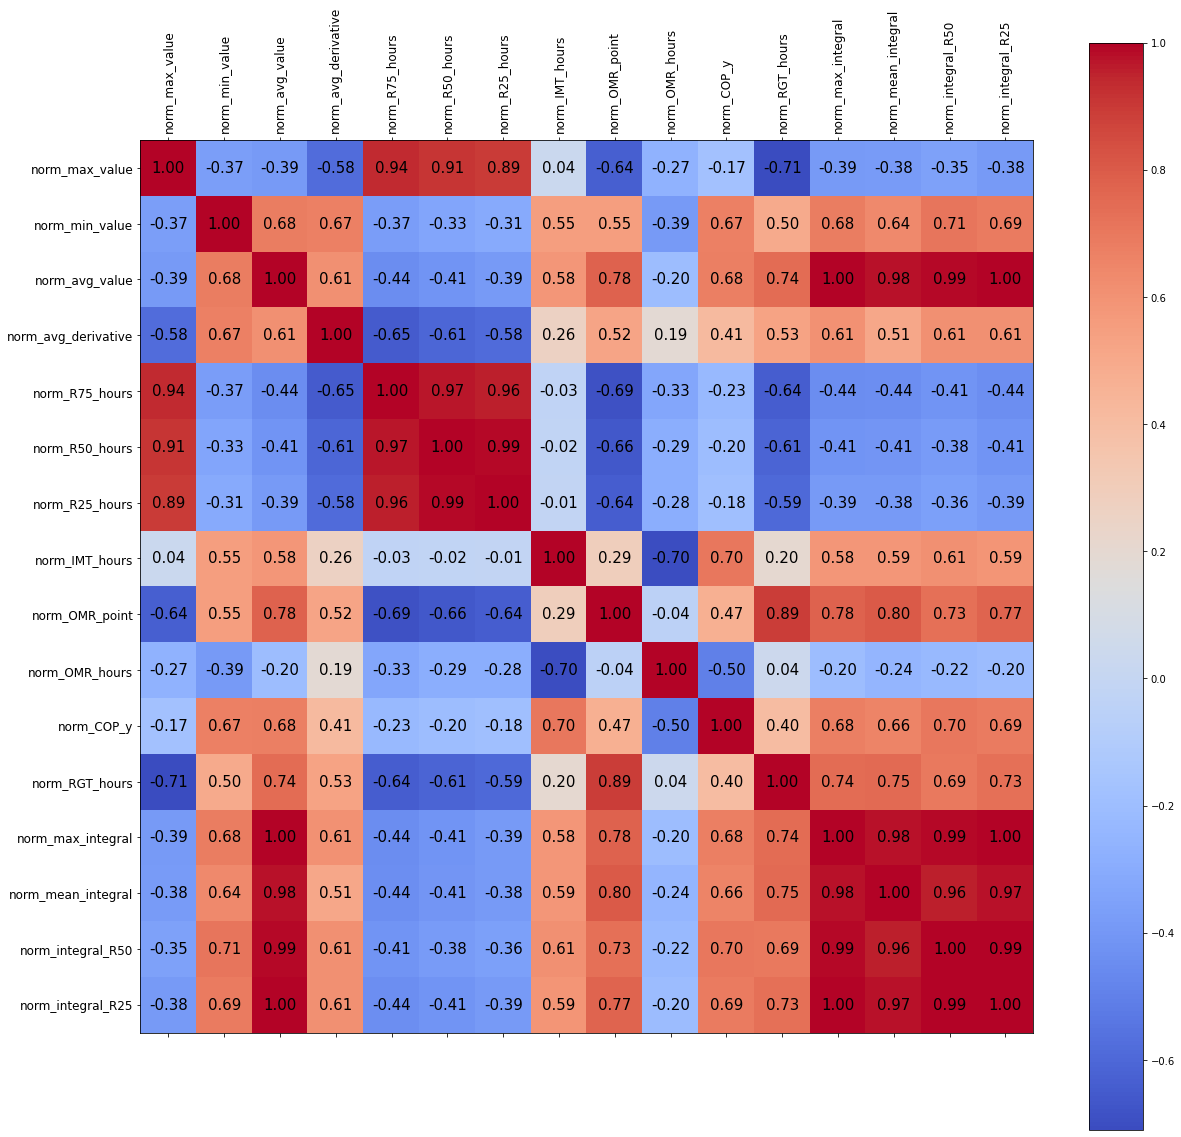

In [ ]:
pairwise_correlation = limited_statistics.T.corr(method='spearman')

index_names = list(limited_statistics.index)

fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot(111)
cax = ax.matshow(pairwise_correlation, interpolation='nearest', cmap = plt.cm.coolwarm)
fig.colorbar(cax)

xaxis = np.arange(len(index_names))
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)

ax.set_xticklabels(index_names, rotation = 90, fontsize = 12)
ax.set_yticklabels(index_names, rotation = 0, fontsize = 12)

for (i, j), z in np.ndenumerate(pairwise_correlation):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', fontsize=15, color='black')

plt.show()

## Applying a logistic regression model to the statistics

KeyError: ignored

In [ ]:
X = limited_statistics.T.values
y = all_statistics.loc['germinated'].values

C = 6
reg_clf = LogisticRegression(C=C, penalty='l1', solver='liblinear', random_state=0) # penalty = 'l1' makes this lasso regularization
clf = LogisticRegression(penalty='none', max_iter = 100000, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf.fit(X_train,y_train)
print(f"\nfor logistic model, score:{clf.score(X_test,y_test)}")
for i, x in enumerate(limited_statistics.index):
    print(f"{x} : \t{clf.coef_[0][i]:2.2f}")

reg_clf.fit(X_train,y_train)
print(f"\nfor regularized logistic model with C={C}, score:{reg_clf.score(X_test,y_test)}")
for i, x in enumerate(limited_statistics.index):
    print(f"{x} : \t{reg_clf.coef_[0][i]:2.2f}")
#print(reg_clf.coef_)



## Use kfold cross validation to estimate an optimal regularization parameter C

In [ ]:
C_test_space = np.arange(0.1, 10, 0.1)
test_scores = []

for C_test_value in C_test_space:
    local_test_score = 0
    kf_splitter = KFold(n_splits=10, shuffle=True, random_state=0)
    for train_indices, test_indices, in kf_splitter.split(X):
        reg_clf = LogisticRegression(C=C_test_value, penalty='l1', solver='liblinear', random_state=0) # penalty = 'l1' makes this lasso classification
        reg_clf.fit(X[train_indices], y[train_indices])
        local_test_score += np.mean(reg_clf.score(X[test_indices], y[test_indices]))
    test_scores.append(local_test_score/10)

for i, test_score in enumerate(test_scores):
    print(f"C_test_value:{C_test_space[i]:2.1f} - test score:{test_score:1.4f}")


## Calculate score for the model with the optimal regularization parameter C

In [ ]:
total_score = []
kf_splitter = KFold(n_splits=10, shuffle=True, random_state=0)
for train_indices, test_indices, in kf_splitter.split(X):
    reg_clf = LogisticRegression(C=6, penalty='l1', solver='liblinear', random_state=0) # penalty = 'l1' makes this lasso classification
    reg_clf.fit(X[train_indices], y[train_indices])
    total_score.append(np.mean(reg_clf.score(X[test_indices], y[test_indices])))

print(np.mean(total_score))

## Plot the (Spearman) correlations of the characteristics found to be strong predictors of germination

In [ ]:
# These are:
# norm_max_value : 	0.35
# norm_min_value : 	4.91
# norm_max_derivative : 	-4.63
# norm_R50_hours : 	-1.96
# norm_R25_hours : 	-1.79
# norm_IMT_hours : 	0.97
# norm_OMR_point : 	-4.85
# norm_OMR_hours : 	1.11
# norm_COP_y : 	-0.04
# norm_RGT_hours : 	-1.87

significant_statistics = limited_statistics.loc[['norm_max_value',
                                            'norm_min_value',
                                            'norm_R50_hours',
                                            'norm_R25_hours',
                                            'norm_IMT_hours',
                                            'norm_OMR_point',
                                            'norm_OMR_hours',
                                            'norm_COP_y',
                                            'norm_RGT_hours']]

pairwise_correlation = significant_statistics.T.corr(method='spearman')

index_names = list(significant_statistics.index)

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
cax = ax.matshow(pairwise_correlation, interpolation='nearest')
fig.colorbar(cax)

xaxis = np.arange(len(index_names))
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)

ax.set_xticklabels(index_names, rotation = 90, fontsize = 12)
ax.set_yticklabels(index_names, rotation = 0, fontsize = 12)

for (i, j), z in np.ndenumerate(pairwise_correlation):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', fontsize=20)

plt.show()

## Plot the histograms of the found variables to show their distribution

In [ ]:
histogram_statistics = limited_statistics.loc[['norm_max_value',
                                                'norm_min_value',
                                                'norm_R50_hours',
                                                'norm_R25_hours',
                                                'norm_OMR_point',
                                                'norm_RGT_hours',
                                                ]]

n_bins = 50

fig, ax = plt.subplots(2, 3, figsize = (15, 10), tight_layout=True)


x = histogram_statistics.loc['norm_max_value']
ax[0,0].hist(x, bins=n_bins)
ax[0,0].set_title('norm_max_value', fontsize=20)
ax[0,0].set_ylabel('Value incidence', fontsize=20)
ax[0,0].set_xlabel('Normalized value', fontsize=20)

x = histogram_statistics.loc['norm_min_value']
ax[0,1].hist(x, bins=n_bins)
ax[0,1].set_title('norm_min_value', fontsize=20)
ax[0,1].set_ylabel('Value incidence', fontsize=20)
ax[0,1].set_xlabel('Normalized value', fontsize=20)

x = histogram_statistics.loc['norm_R50_hours']
ax[0,2].hist(x, bins=n_bins)
ax[0,2].set_title('norm_R50_hours', fontsize=20)
ax[0,2].set_ylabel('Value incidence', fontsize=20)
ax[0,2].set_xlabel('Normalized value', fontsize=20)

x = histogram_statistics.loc['norm_R25_hours']
ax[1,0].hist(x, bins=n_bins)
ax[1,0].set_title('norm_R25_hours', fontsize=20)
ax[1,0].set_ylabel('Value incidence', fontsize=20)
ax[1,0].set_xlabel('Normalized value', fontsize=20)

x = histogram_statistics.loc['norm_OMR_point']
ax[1,1].hist(x, bins=n_bins)
ax[1,1].set_title('norm_OMR_point', fontsize=20)
ax[1,1].set_ylabel('Value incidence', fontsize=20)
ax[1,1].set_xlabel('Normalized value', fontsize=20)

x = histogram_statistics.loc['norm_RGT_hours']
ax[1,2].hist(x, bins=n_bins)
ax[1,2].set_title('norm_RGT_hours', fontsize=20)
ax[1,2].set_ylabel('Value incidence', fontsize=20)
ax[1,2].set_xlabel('Normalized value', fontsize=20)


# Visualization of the values mentioned above

In [ ]:
hour_points = np.array(range(571))*(1/6)

fig, axes = plt.subplots(1, 3, figsize=(60, 15))

axes[0].set_ylim(0.0, 1.0)
axes[0].set_xlim(0, max(hour_points))
axes[0].grid()

axes[1].set_ylim(-0.015, 0.015)
axes[1].set_xlim(0, max(hour_points))
axes[1].grid()

axes[2].set_ylim(-0.0002, 0.0002)
axes[2].set_xlim(0, max(hour_points))
axes[2].grid()

spline_name = all_seed_names[index]
index += 1
print(spline_name)
while not spline_name in only_germ_astec_data_df:
    print(f'skipped {index} name:{spline_name} because there was no proper germination')
    if index >= len(all_seed_names):
        index = 0
    index += 1
    spline_name = all_seed_names[index]

print(f'Found spline {spline_name}!')
spline_statistics = calculated_statistics[spline_name]
target_spline_statistics = only_germ_astec_data_df[spline_name]

spline = splines[spline_name]
first_derivative = np.diff(spline)
second_derivative = np.diff(first_derivative)

axes[0].plot(hour_points, interpolated_oxygen_df[spline_name])
axes[0].plot(hour_points, spline, 'r')
axes[1].plot(hour_points[:-1], first_derivative, 'r')
axes[2].plot(hour_points[:-2], second_derivative, 'r')

# plot the calculated astec values
for i in range(3):
    # IMT
    axes[i].vlines(x = spline_statistics.IMT_hours, ymin = -0.1, ymax = 1, colors = 'b', linestyles = 'dotted')
    axes[i].text(x = spline_statistics.IMT_hours / 95, y = 0.55, s = 'IMT', fontsize = 'x-large', transform=axes[i].transAxes)
    # COP
    axes[i].vlines(x = spline_statistics.COP_hours, ymin = -0.1, ymax = 1, colors = 'b', linestyles = 'dotted')
    axes[i].text(x = spline_statistics.COP_hours / 95, y = 0.55, s = 'COP', fontsize = 'x-large', transform=axes[i].transAxes)
    # RGT
    axes[i].vlines(x = spline_statistics.RGT_hours, ymin = -0.1, ymax = 1, colors = 'b', linestyles = 'dotted')
    axes[i].text(x = spline_statistics.RGT_hours / 95, y = 0.55, s = 'RGT', fontsize = 'x-large', transform=axes[i].transAxes)
    
# plot the target astec values
for i in range(3):
    # IMT
    axes[i].vlines(x = target_spline_statistics.IMT_hours, ymin = -0.1, ymax = 1, colors = 'g', linestyles = 'dotted')
    axes[i].text(x = target_spline_statistics.IMT_hours / 95, y = 0.45, s = 'target IMT', fontsize = 'x-large', transform=axes[i].transAxes)
    # COP
    axes[i].vlines(x = target_spline_statistics.COP_hours, ymin = -0.1, ymax = 1, colors = 'g', linestyles = 'dotted')
    axes[i].text(x = target_spline_statistics.COP_hours / 95, y = 0.45, s = 'target COP', fontsize = 'x-large', transform=axes[i].transAxes)
    # RGT
    axes[i].vlines(x = target_spline_statistics.RGT, ymin = -0.1, ymax = 1, colors = 'g', linestyles = 'dotted')
    axes[i].text(x = target_spline_statistics.RGT / 95, y = 0.45, s = 'target RGT', fontsize = 'x-large', transform=axes[i].transAxes)